## Question: How does Zipf's Exponent change with sample size?

Our entire thesis is that Zipf's Law and Heap's Law are (excellent) approximations for describing text, but ultimately wrong. Let's face it, if they're wrong, it's not by much. So, if these integral/polylogarithmic functions are correct, then what's the "apparent" Zipf exponent $\alpha(x)$, and is there a compelling derivation that matches the empirical curve?

In [1]:
# bloody dependencies
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE
from scipy.special import zeta, zetac
from scipy.optimize import fsolve

# custom classes
from legomena import Corpus, SPGC

In [2]:
# standard project gutenberg corpus
spgc = SPGC.getMeta()

# for now, restrict study to english-only
spgc = spgc[spgc.language == "['en']"]

# preview
spgc.head()

,title,author,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type
id,,,,,,,,
1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text
2,The United States Bill of Rights: The Ten Orig...,United States,NaN,NaN,['en'],158.0,"{'Civil rights -- United States -- Sources', '...",Text
3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917.0,1963.0,['en'],28.0,{'Presidents -- United States -- Inaugural add...,Text
4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809.0,1865.0,['en'],55.0,{'Consecration of cemeteries -- Pennsylvania -...,Text
5,The United States Constitution,United States,NaN,NaN,['en'],226.0,"{'United States. Constitution', 'United States...",Text


In [3]:
def zetainv(h):
    func = lambda z: zeta(z) - h
    z0 = 1.1
    z = fsolve(func, z0)[0]
    return z

def hapax(x):
    if abs(x-1) < 0.001:
        return 0.5
    return 1./np.log(x) - 1./(x-1)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Choosing a Book

Select a book for use as our fitting corpus.

Number of tokens (<corpus>.M): 210258
Number of types  (<corpus>.N): 16402
Legomena vector  (<corpus>.k): [   0 7197 2781 1555  872  632  439  338  303]
Frequency distribution accessible as <corpus>.fdist
Type-Token Relation data accessible as <corpus>.TTR
Log model accessible as <corpus>.M_z, .N_z
Optimum (M_z,N_z) = (112476, 12214)


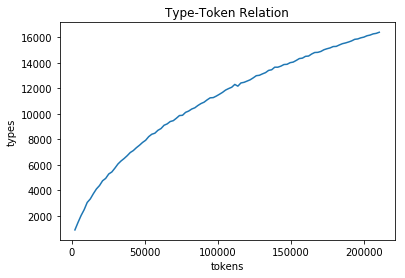

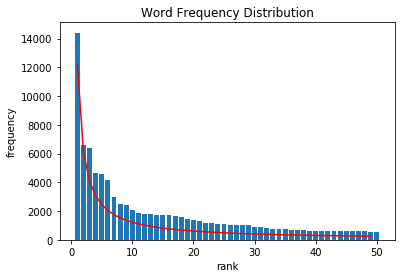

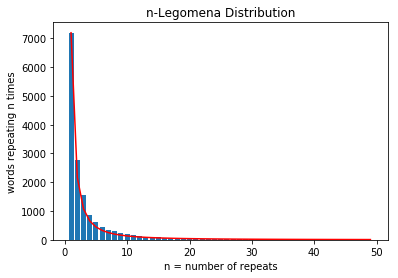

In [5]:
# spgc[spgc.title.str.contains("Bible", na = False)].head()

# moby dick
corpus = SPGC.get(2701)
df = corpus.buildTTRCurve(legomena_upto=20)
M_z, N_z = corpus.fit(optimize = True)
print("Optimum (M_z,N_z) =", (M_z, N_z))

# plot TTR curve
plt.plot(df.m_tokens, df.n_types)
plt.title("Type-Token Relation")
plt.xlabel("tokens")
plt.ylabel("types")
plt.show()

# plot WFD
xmax = 50
i = np.arange(1, xmax)
df = corpus.fdist.copy().head(xmax)
plt.bar(df["rank"], df["freq"])
plt.plot(i, corpus.N_z/i, color = 'r')
plt.title("Word Frequency Distribution")
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

# plot the k-vector
B = zetainv(2.)
plt.bar(i, corpus.k[i])
plt.plot(i, corpus.k[1]/i**B, color = 'r')
plt.title("n-Legomena Distribution")
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.show()

x = 1
Expected hapax proportion: 0.5
Best-Fit alpha: 1.7286472389981808
Observed p_n: [0.49474947 0.14351435 0.07880788 0.04840484 0.03120312 0.02490249
 0.01770177 0.01520152]
Expected p_n: [0.5        0.16666667 0.08333333 0.05       0.03333333]


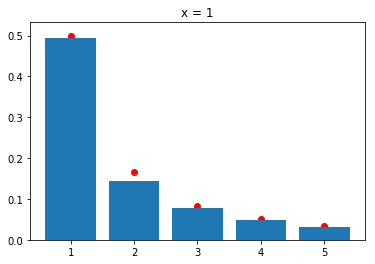

In [6]:
x = np.random.uniform(0.01, 1.99)
x = 1
print("x =", x)
h_exp = hapax(x)
print("Expected hapax proportion:", h_exp)
alpha = zetainv(1/h_exp)
print("Best-Fit alpha:", alpha)

y = np.random.zipf(alpha, 9999)
_, y = np.unique(y, return_counts = True) # group
y = y / sum(y) # normalize
p_obs = np.concatenate((np.array([0.]), y))
print("Observed p_n:", p_obs[1:9])

E, k_exp = corpus.log_formula(x)
p_exp = k_exp[0] / E
print("Expected p_n:", p_exp[1:])

L = len(p_exp)
i = np.arange(1, L)
plt.bar(i, p_obs[1:L])
plt.scatter(i, p_exp[1:L], color = 'r')
plt.title("x = " + str(x))
plt.show()

In [7]:
k = np.arange(1, 9)
s = zetainv(2.)
print(k**-s/zeta(s))
print(1./k/(k+1))

[0.5        0.15086737 0.07485067 0.04552193 0.03095262 0.02258505
 0.01730189 0.01373555]
[0.5        0.16666667 0.08333333 0.05       0.03333333 0.02380952
 0.01785714 0.01388889]


,m_tokens,n_types,lego_0,lego_1,lego_2,lego_3,lego_4,lego_5,lego_6,lego_7,...,lego_15_p_obs,lego_15_p_exp,lego_16_p_obs,lego_16_p_exp,lego_17_p_obs,lego_17_p_exp,lego_18_p_obs,lego_18_p_exp,lego_19_p_obs,lego_19_p_exp
0,2102,902,15500,667,111,38,22,12,7,10,...,0.000000,0.000656,0.002217,0.000554,0.000000,0.000473,0.000000,0.000407,0.006652,0.000354
1,4205,1484,14918,1065,178,80,37,19,17,7,...,0.002022,0.000964,0.002695,0.000823,0.002022,0.000709,0.002695,0.000616,0.002695,0.000540
2,6307,2027,14375,1447,257,89,42,33,26,15,...,0.002960,0.001207,0.000987,0.001037,0.001480,0.000899,0.002467,0.000785,0.000987,0.000691
3,8410,2485,13917,1758,306,126,66,42,19,22,...,0.001610,0.001413,0.002012,0.001219,0.001207,0.001061,0.000402,0.000931,0.000402,0.000823
4,10512,3056,13346,2167,398,145,82,39,31,18,...,0.002291,0.001595,0.001636,0.001380,0.001309,0.001205,0.001309,0.001061,0.000982,0.000940


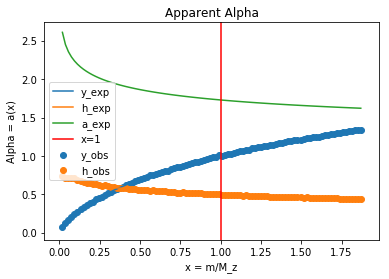

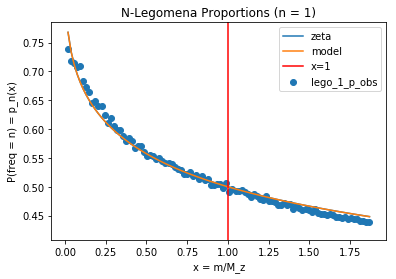

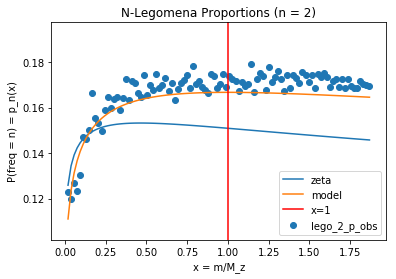

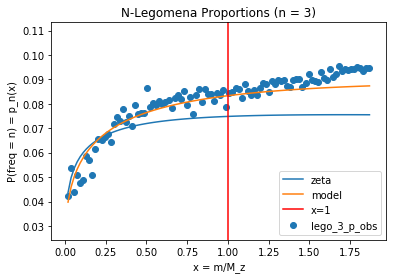

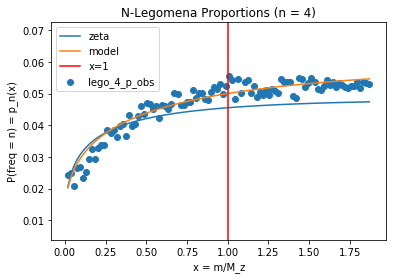

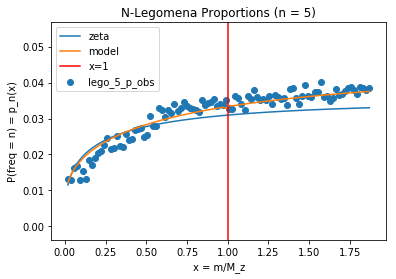

In [13]:
# calculate apparent alpha
df = corpus.TTR.copy()
# df = df[["m_tokens", "n_types", "lego_1", "lego_4"]]
df["x"] = df.m_tokens / corpus.M_z
E_x, k_x = corpus.log_formula(df.x)

df["y_obs"] = df.n_types / corpus.N_z
df["y_exp"] = E_x
df["h_obs"] = df.lego_1 / df.n_types
df["h_exp"] = k_x[:,1] / df["y_exp"] # eww
df["a_exp"] = [ zetainv(1/h) for h in df["h_exp"] ]

for col in df.columns:
    if "lego_" in col:
        n = float(col.split("_")[1])
        df[col + "_p_obs"] = df[col] / df.n_types
        df[col + "_p_exp"] = df["h_exp"] / n**df["a_exp"]
        if n < 6:
            df[col + "_p_mod"] = k_x[:,int(n)] / df["y_exp"] # eww
display(df.head())

# draw a pretty plot
plt.plot(df["x"], df["y_exp"], label = "y_exp")
plt.plot(df["x"], df["h_exp"], label = "h_exp")
plt.plot(df["x"], df["a_exp"], label = "a_exp")
plt.scatter(df["x"], df["y_obs"], label = "y_obs")
plt.scatter(df["x"], df["h_obs"], label = "h_obs")
plt.axvline(x = 1, color = 'r', label = "x=1")
plt.xlabel("x = m/M_z")
plt.ylabel("Alpha = a(x)")
plt.legend()
plt.title("Apparent Alpha")
plt.show()

# draw more pretty plots
for n in range(1, 6):
    plt.scatter(df["x"], df[f"lego_{n}_p_obs"], label = f"lego_{n}_p_obs")
    plt.plot(df["x"], df[f"lego_{n}_p_exp"], label = "zeta")
    plt.plot(df["x"], df[f"lego_{n}_p_mod"], label = "model")
    plt.axvline(x = 1, color = 'r', label = "x=1")
    plt.xlabel("x = m/M_z")
    plt.ylabel("P(freq = n) = p_n(x)")
    plt.legend()
    plt.title(f"N-Legomena Proportions (n = {n})")
    plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/victor/.local/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


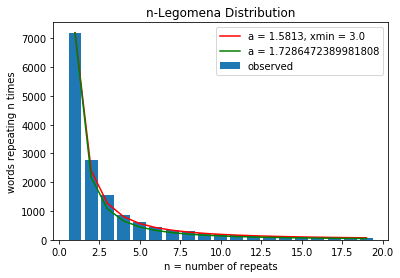

In [9]:
import powerlaw
# tokens = np.random.choice(corpus.tokens, corpus.M_z, replace = False)
# opticorpus = Corpus(tokens)
dist = powerlaw.Fit(corpus.k[1:]).power_law
alpha, xmin = dist.alpha, dist.xmin

i = np.arange(1, 20)
B = zetainv(2.)
plt.bar(i, corpus.k[i], label = "observed")
plt.plot(i, corpus.k[1]/i**alpha, color = 'r', label = f"a = {alpha:0.4f}, xmin = {xmin}")
plt.plot(i, corpus.k[1]/i**B, color = 'g', label = f"a = {B}")
plt.title("n-Legomena Distribution")
plt.xlabel("n = number of repeats")
plt.ylabel("words repeating n times")
plt.legend()
plt.show()

## Conclusion

Sadly, I can't seem to square this concept. Although the $n$-legomena proportions appear to converge on a Zeta Distribution in the limit, taking this idea literally does not appear to bear fruit. Look no further than the dis legomena prediction at $x=1$. Our model predicts $p_2(1) = 1/6 \approx 0.1667$ which is far closer to empirical observations than a Zeta Distribution, in which $p_2(1) = p_1(1) / 2^{\zeta^{-1}(1/p_1(1))} \approx 0.5/2^{1.72864723899818} \approx 0.15086737$.

Having said that, the curves really do _look_ and _behave_ somewhat the same, even though they clearly aren't _equal_. So it's conceivable there is some deeper connection between the two or some conversion factor buried in the math linking the polylogarithms to a simple exponent. Seems like an outside chance, but it can't be ruled out that some modification to a Zeta Distribution may fit the data.